# Régression logistique

Prédire la couleur d'un vin à partir de ses composants.

In [1]:
%matplotlib inline

In [2]:
from papierstat.datasets import load_wines_dataset
data = load_wines_dataset()
X = data.drop(['quality', 'color'], axis=1)
y = data['color']

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [4]:
from sklearn.linear_model import LogisticRegression
clr = LogisticRegression()
clr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

La première façon de vérifier que le modèle a marché consiste à regarder la matrice de confusion.

In [5]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_test, clr.predict(X_test))
conf

array([[ 372,   25],
       [  10, 1218]], dtype=int64)

Les coefficients sur la diagonale indique les éléments bien classés, les coefficients en dehors ceux que le classifieur a mis dans la mauvaise classe.

In [6]:
import pandas
cf = pandas.DataFrame(conf, columns=['prédit ' + _ for _ in clr.classes_])
cf.index = ['vrai ' + _ for _ in clr.classes_]
cf

,prédit red,prédit white
vrai red,372,25
vrai white,10,1218


Un classifieur construit une frontière entre deux classes, la distance d'un point à la frontière consistue une information importante. Plus elle est grande, plus le modèle est confiant. Cette distance est souvent appelée *score*.

In [7]:
clr.decision_function(X_test)

array([ 1.60728181,  4.70815767, -6.85797467, ...,  5.19146125,
        6.27791633, -5.84703006])

Mais on préfère les probabilités quand elles sont disponibles :

In [8]:
clr.predict_proba(X_test)

array([[0.16696634, 0.83303366],
       [0.00894072, 0.99105928],
       [0.99895006, 0.00104994],
       ...,
       [0.00553309, 0.99446691],
       [0.00187379, 0.99812621],
       [0.99711985, 0.00288015]])

Voyons comment le score est distribué :

In [9]:
score = clr.decision_function(X_test)
dfsc = pandas.DataFrame(score, columns=['score'])
dfsc['color'] = y_test
dfsc.head()

,score,color
0,1.607282,NaN
1,4.708158,NaN
2,-6.857975,NaN
3,-1.747891,NaN
4,-2.883700,NaN


Visiblement, pandas n'a pas compris ce que je voulais qu'il fasse. Il a utilisé les indices de la série *y_test* et a utilisé *y_test.index* comme indice de tableau. Changeons cela.

In [10]:
dfsc = pandas.DataFrame(score, columns=['score'])
dfsc['color'] = y_test.as_matrix()
dfsc.head()

,score,color
0,1.607282,white
1,4.708158,white
2,-6.857975,red
3,-1.747891,red
4,-2.883700,red


Text(0.5,1,'Distribution des scores de classification couleur')

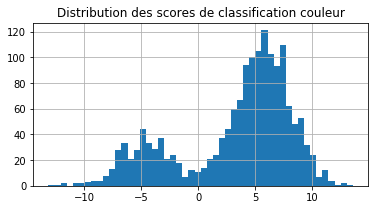

In [11]:
ax = dfsc['score'].hist(bins=50, figsize=(6,3))
ax.set_title('Distribution des scores de classification couleur')

Deux modes, probablement les deux classes. Pour en être sûr :

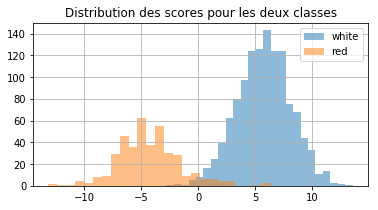

In [12]:
ax = dfsc[dfsc['color'] == 'white']['score'].hist(bins=25, figsize=(6,3), label='white', alpha=0.5)
dfsc[dfsc['color'] == 'red']['score'].hist(bins=25, ax=ax, label='red', alpha=0.5)
ax.set_title("Distribution des scores pour les deux classes")
ax.legend();

Il y a quelques confusions autour de 0 mais le modèle est pertinent au sens où la frontière entre les deux classes est assez nette : les deux cloches ne se superposent pas. Voyons avec les probabilités :

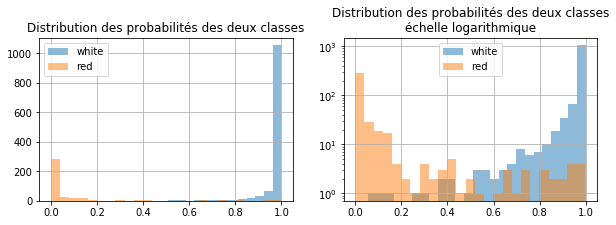

In [13]:
proba = clr.predict_proba(X_test)[:, 1]
dfpr = pandas.DataFrame(proba, columns=['proba'])
dfpr['color'] = y_test.as_matrix()

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10,3))
dfpr[dfpr['color'] == 'white']['proba'].hist(bins=25, label='white', alpha=0.5, ax=ax[0])
dfpr[dfpr['color'] == 'red']['proba'].hist(bins=25, label='red', alpha=0.5, ax=ax[0])
ax[0].set_title('Distribution des probabilités des deux classes')
ax[0].legend();
dfpr[dfpr['color'] == 'white']['proba'].hist(bins=25, label='white', alpha=0.5, ax=ax[1])
dfpr[dfpr['color'] == 'red']['proba'].hist(bins=25, label='red', alpha=0.5, ax=ax[1])
ax[1].set_yscale('log')
ax[1].set_title('Distribution des probabilités des deux classes\néchelle logarithmique')
ax[1].legend();

Plus l'aire commune aux deux distributions est petite, plus le modèle est confiant. Cette aire commune est reliée à la courbe [ROC](https://fr.wikipedia.org/wiki/Courbe_ROC).

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
probas = clr.predict_proba(X_test)
fpr0, tpr0, thresholds0 = roc_curve(y_test, probas[:, 0], pos_label=clr.classes_[0], drop_intermediate=False)
fpr0.shape

(1530,)

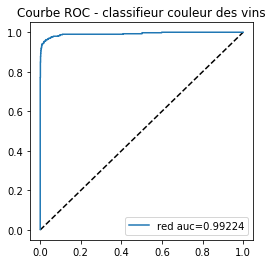

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot([0, 1], [0, 1], 'k--')
# aucf = roc_auc_score(y_test == clr.classes_[0], probas[:, 0]) # première façon
aucf = auc(fpr0, tpr0)  # seconde façon
ax.plot(fpr0, tpr0, label=clr.classes_[0] + ' auc=%1.5f' % aucf)
ax.set_title('Courbe ROC - classifieur couleur des vins')
ax.legend();

La mesure [AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) ou Area Under the Curve est l'aire sous la courbe. Elle est égale à la probabilité que le score d'un exemple classé rouge à raison soit inférieur à un exemple classé rouge à tort. On vérifie.

In [16]:
from random import randint
n1, n2 = 0, 0
yt = y_test.as_matrix()

for n in range(0, 100000):
    i = randint(0, len(yt)-1)
    j = randint(0, len(yt)-1)
    s1, p1 = probas[i, 0], yt[i] == clr.classes_[0]
    s2, p2 = probas[j, 0], yt[j] == clr.classes_[0]
    if p1 != p2:
        if p1:
            if s1 < s2:
                n1 += 1
            else:
                n2 += 1
        else:
            if s1 > s2:
                n1 += 1
            else:
                n2 += 1
print(n2*1.0/(n1 + n2))

0.992342659234807


Presque cela, la fonction [auc]() utilise la fontion [trapz](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.trapz.html) et qui calcule une aire et non pas une probabilité comme-ci dessus.

## Un peu plus loin à propos de la courbe ROC

Voyons ce qu'il se passe en général si nous décidons non pas d'évaluer un modèle qui classifie bien une classe mais les deux classes à la fois. La différence est subtile. Le score est celui de la classe prédite et non plus celui d'une classe.

In [17]:
list_classes = list(clr.classes_)

pred = clr.predict(X_test)
scores = clr.decision_function(X_test)
pred_i = [list_classes.index(c) for c in pred]
probas = clr.predict_proba(X_test)
proba = [probas[i, c] for i, c in enumerate(pred_i)]
score = [scores[i] if c == 0 else -scores[i]  for i, c in enumerate(pred_i)]

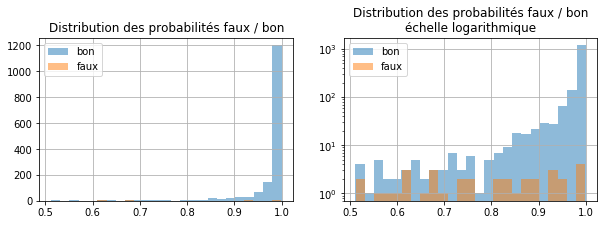

In [18]:
dfpr = pandas.DataFrame(proba, columns=['proba'])
dfpr['color'] = y_test.as_matrix()

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10,3))
dfpr[pred == dfpr['color']]['proba'].hist(bins=25, label='bon', alpha=0.5, ax=ax[0])
dfpr[pred != dfpr['color']]['proba'].hist(bins=25, label='faux', alpha=0.5, ax=ax[0])
ax[0].set_title('Distribution des probabilités faux / bon')
ax[0].legend();
dfpr[pred == dfpr['color']]['proba'].hist(bins=25, label='bon', alpha=0.5, ax=ax[1])
dfpr[pred != dfpr['color']]['proba'].hist(bins=25, label='faux', alpha=0.5, ax=ax[1])
ax[1].set_yscale('log')
ax[1].set_title('Distribution des probabilités faux / bon\néchelle logarithmique')
ax[1].legend();

Et avec les scores et non plus les probabilités.

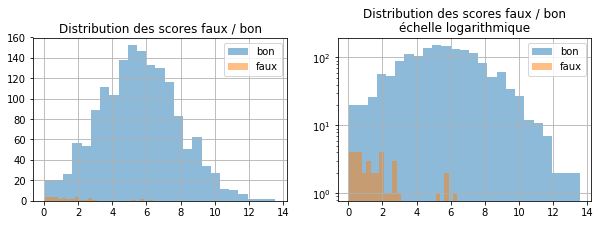

In [19]:
scores = clr.decision_function(X_test)
dfsc = pandas.DataFrame(scores, columns=['score'])
dfsc.loc[pred == 'red', 'score'] *= -1
dfsc['color'] = y_test.as_matrix()

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10,3))
dfsc[pred == dfsc['color']]['score'].hist(bins=25, label='bon', alpha=0.5, ax=ax[0])
dfsc[pred != dfsc['color']]['score'].hist(bins=25, label='faux', alpha=0.5, ax=ax[0])
ax[0].set_title('Distribution des scores faux / bon')
ax[0].legend();
dfsc[pred == dfsc['color']]['score'].hist(bins=25, label='bon', alpha=0.5, ax=ax[1])
dfsc[pred != dfsc['color']]['score'].hist(bins=25, label='faux', alpha=0.5, ax=ax[1])
ax[1].set_yscale('log')
ax[1].set_title('Distribution des scores faux / bon\néchelle logarithmique')
ax[1].legend();

In [20]:
fpr, tpr, thresholds = roc_curve(pred == y_test, proba)

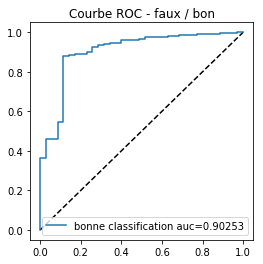

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot([0, 1], [0, 1], 'k--')
aucf = auc(fpr, tpr)  # seconde façon
ax.plot(fpr, tpr, label='bonne classification auc=%1.5f' % aucf)
ax.set_title('Courbe ROC - faux / bon')
ax.legend();

In [22]:
n1, n2 = 0, 0
yt = y_test.as_matrix()

for n in range(0, 100000):
    i = randint(0, len(yt)-1)
    j = randint(0, len(yt)-1)
    
    s1, p1 = proba[i], yt[i] == pred[i]
    s2, p2 = proba[j], yt[j] == pred[j]
    if p1 != p2:
        if p1:
            if s1 < s2:
                n1 += 1
            else:
                n2 += 1
        else:
            if s1 > s2:
                n1 += 1
            else:
                n2 += 1
print(n2*1.0/(n1 + n2))

0.8987401949132399


Mais pourquoi les résultats sont-ils moins bons ? Première AUC :

In [23]:
pred = clr.predict(X_test)
scores = clr.decision_function(X_test)
roc_auc_score(y_test == 'white', scores)

0.9922423058935501

Seconde AUC, on suppose que 0 est la frontière entre les deux classes. Si le score est supérieure à 0, le vin est blanc, sinon il est rouge.

In [24]:
import numpy
pred = numpy.array(['red' if s < 0 else 'white' for s in scores])
fpr0, tpr0, thresholds0 = roc_curve(y_test == pred, numpy.abs(scores), drop_intermediate=False)
auc(fpr0, tpr0)

0.902533692722372

Mais ce n'est peut-être pas le meilleur seuil ? Regardons.

In [25]:
ths = []
aucs = []
n = 100
a, b = -1, 2
for thi in range(0, n+1):
    th = a + thi * (b-a) * 1. / n
    ths.append(th)
    pred = numpy.array(['red' if s - th < 0 else 'white' for s in scores])
    fpr, tpr, _ = roc_curve(y_test == pred, numpy.abs(scores - th), drop_intermediate=False)
    aucs.append(auc(fpr, tpr))

In [26]:
dfa = pandas.DataFrame(dict(th=ths, AUC=aucs))
dfa.describe().T

,count,mean,std,min,25%,50%,75%,max
AUC,101.0,0.913654,0.009667,0.897666,0.90387,0.916827,0.922405,0.929737
th,101.0,0.500000,0.879005,-1.000000,-0.25000,0.500000,1.250000,2.000000


Text(0.5,1,"Evolution de l'AUC en fonction\ndu seuil de décision")

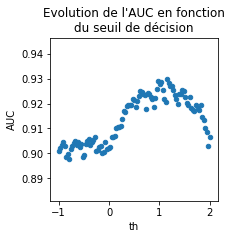

In [27]:
ax = dfa.plot(x='th', y='AUC', figsize=(3, 3), kind='scatter')
ax.set_title("Evolution de l'AUC en fonction\ndu seuil de décision")

Ca aide mais ce n'est toujours pas ça. Changer le seuil aide, il faudrait maintenant changer l'échelle du score, ce qu'on ne fera pas mais rien n'empêche de tracer les fonctions de répartition des scores négatifs et positifs... Voici les distributions.

In [28]:
score = clr.decision_function(X_test)
dfsc = pandas.DataFrame(score, columns=['score'])
dfsc['color'] = y_test.ravel()
dfsc['score_abs'] = dfsc['score'].abs()

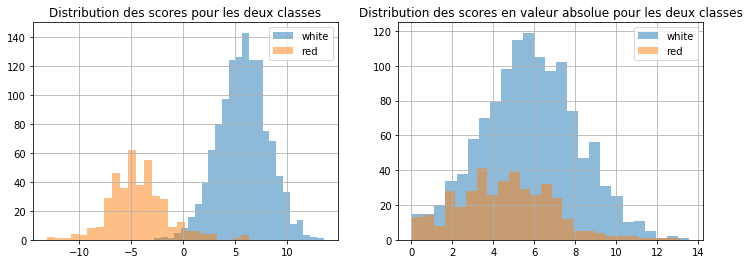

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
dfsc[dfsc['color'] == 'white']['score'].hist(bins=25, label='white', alpha=0.5, ax=ax[0])
dfsc[dfsc['color'] == 'red']['score'].hist(bins=25, label='red', alpha=0.5, ax=ax[0])
ax[0].set_title("Distribution des scores pour les deux classes")
ax[0].legend()
dfsc[dfsc['color'] == 'white']['score_abs'].hist(bins=25, label='white', alpha=0.5, ax=ax[1])
dfsc[dfsc['color'] == 'red']['score_abs'].hist(bins=25, label='red', alpha=0.5, ax=ax[1])
ax[1].set_title("Distribution des scores en valeur absolue pour les deux classes")
ax[1].legend();

In [30]:
red = dfsc[dfsc['color'] == 'red'].sort_values('score_abs').reset_index(drop=True)
red["count"] = 1
red['count_sum'] = red['count'].cumsum() * 1. / red.shape[0]
red.tail(n=2)

,score,color,score_abs,count,count_sum
395,-12.455729,red,12.455729,1,0.997481
396,-13.128251,red,13.128251,1,1.000000


In [31]:
white = dfsc[dfsc['color'] == 'white'].sort_values('score_abs').reset_index(drop=True)
white["count"] = 1
white['count_sum'] = white['count'].cumsum() * 1. / white.shape[0]
white.tail(n=2)

,score,color,score_abs,count,count_sum
1226,12.677271,white,12.677271,1,0.999186
1227,13.544138,white,13.544138,1,1.000000


In [32]:
dfscsumabs = pandas.concat([red, white])

On fait pareil pour le score.

In [33]:
red = dfsc[dfsc['color'] == 'red'].sort_values('score', ascending=False).reset_index(drop=True)
red["count"] = 1
red['count_sum'] = red['count'].cumsum() * 1. / red.shape[0]
white = dfsc[dfsc['color'] == 'white'].sort_values('score').reset_index(drop=True)
white["count"] = 1
white['count_sum'] = white['count'].cumsum() * 1. / white.shape[0]
dfscsum = pandas.concat([red, white])

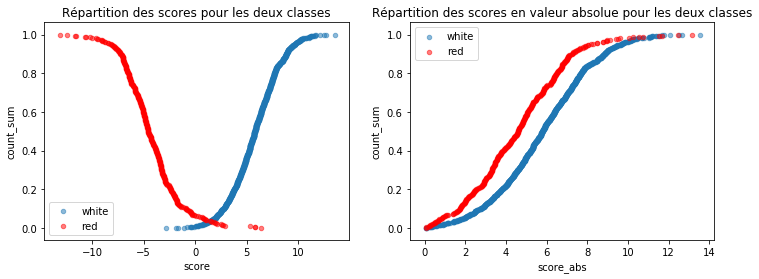

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
dfscsum[dfscsum['color'] == 'white'].plot(x='score', y='count_sum', kind='scatter',
                                          label='white', alpha=0.5, ax=ax[0])
dfscsum[dfscsum['color'] == 'red'].plot(x='score', y='count_sum', kind='scatter', color='red',
                                        label='red', alpha=0.5, ax=ax[0])
ax[0].set_title("Répartition des scores pour les deux classes")
ax[0].legend()
dfscsumabs[dfscsumabs['color'] == 'white'].plot(x='score_abs', y='count_sum', kind='scatter',
                                          label='white', alpha=0.5, ax=ax[1])
dfscsumabs[dfscsumabs['color'] == 'red'].plot(x='score_abs', y='count_sum', kind='scatter', color='red',
                                        label='red', alpha=0.5, ax=ax[1])
ax[1].set_title("Répartition des scores en valeur absolue pour les deux classes")
ax[1].legend();

Les deux courbes ne sont pas confondues. Cela veut dire que le score des vins blancs et celui des rouges ne suivent pas les mêmes distributions.